In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib.layers import fully_connected

Input data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Params

In [3]:
num_inputs=784    #28x28 pixels
num_hid1=392
num_hid2=196
num_hid3=num_hid1
num_output=num_inputs
lr=0.01
actf=tf.nn.relu

In [8]:
# setting params
num_epoch=5
batch_size=150
num_test_images=10

#### Model

In [4]:
X=tf.placeholder(tf.float32,shape=[None,num_inputs])
initializer=tf.variance_scaling_initializer()

w1=tf.Variable(initializer([num_inputs,num_hid1]),dtype=tf.float32)
w2=tf.Variable(initializer([num_hid1,num_hid2]),dtype=tf.float32)
w3=tf.Variable(initializer([num_hid2,num_hid3]),dtype=tf.float32)
w4=tf.Variable(initializer([num_hid3,num_output]),dtype=tf.float32)

b1=tf.Variable(tf.zeros(num_hid1))
b2=tf.Variable(tf.zeros(num_hid2))
b3=tf.Variable(tf.zeros(num_hid3))
b4=tf.Variable(tf.zeros(num_output))

hid_layer1=actf(tf.matmul(X,w1)+b1)
hid_layer2=actf(tf.matmul(hid_layer1,w2)+b2)
hid_layer3=actf(tf.matmul(hid_layer2,w3)+b3)
output_layer=actf(tf.matmul(hid_layer3,w4)+b4)

#### loss, opt

Practice

In [49]:
a = tf.constant(np.ones((100,2,2,1)))

In [50]:
b = tf.constant(2*np.ones((100,2,2,1)))

In [51]:
c = tf.reduce_mean(
            tf.reduce_sum(
                tf.square(tf.subtract(b,a))
            , axis=(1,2)
            )
        )

In [61]:
d = tf.add(c, tf.multiply( tf.constant(0.1 ,tf.float64), c))

In [62]:
init=tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(d)
    print(d.eval())

4.4


main

In [5]:
def loss_fn(ouput_layer, X):
    return tf.reduce_mean(tf.square(output_layer-X))

In [92]:
def dev_loss_fn(ouput_layer, X, batch_size, c_lambda):

    def rotate_opetation(imgs, oimgs):
        loss_list = []
        # rotate list
        angle_list = [i for i in range(5,360,15)]
        for angles in angle_list:
            rimgs = tf.contrib.image.rotate(
                oimgs,
                tf.constant(angles ,dtype=tf.float32),
                interpolation='NEAREST',
                name=None
            )
            loss_reconst = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(imgs-rimgs)
                , axis=(1,2)
                )
            )
            loss_list.append(loss_reconst)
        return loss_list
    
    with tf.variable_scope("gradient"):   
        # set shape
        outputs = tf.reshape(output_layer, [batch_size, 28,28,1])
        labels  = tf.reshape(X, [batch_size, 28,28,1])
        
        ### rotate for resoncstraction
        """
        argmax_theta | z(x) - z(R_theta x)|
        """
        loss_list = rotate_opetation(outputs, outputs)
        loss_reconst = tf.reduce_max(tf.stack(loss_list))
    
        ### rotate for image
        """
        argmin_theta | x - R_theta x|
        """
        loss_list = rotate_opetation(labels, outputs)
        loss_img = tf.reduce_min(tf.stack(loss_list))
    
        loss_reconst = tf.multiply(tf.constant(c_lambda ,dtype=tf.float32) , loss_reconst )
        return tf.add(loss_img ,loss_reconst)
        #return tf.add(loss_img , loss_reconst ) 

In [99]:
#loss= loss_fn(output_layer, X) # original
c_lambda = 1.0
loss= dev_loss_fn(output_layer, X, batch_size, c_lambda)  # rotate invariant

optimizer=tf.train.AdamOptimizer(lr)
train_ops=optimizer.minimize(loss)

#### Train c_lambda=1.0

epoch 0 loss 47.06494140625
epoch 1 loss 44.25304412841797
epoch 2 loss 48.30340576171875
epoch 3 loss 47.10863494873047
epoch 4 loss 46.93739700317383


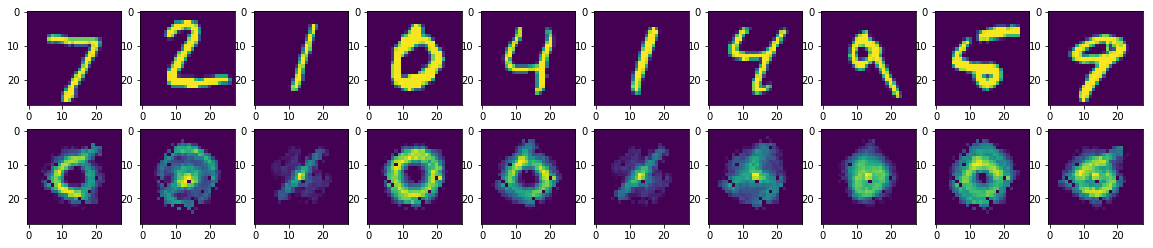

In [100]:
# initialize
init=tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epoch):
        
        num_batches=mnist.train.num_examples//batch_size
        for iteration in range(num_batches):
            X_batch,y_batch=mnist.train.next_batch(batch_size)
            sess.run(train_ops,feed_dict={X:X_batch})
            
        train_loss=loss.eval(feed_dict={X:X_batch})
        print("epoch {} loss {}".format(epoch,train_loss))
    
    results=output_layer.eval(feed_dict={X:mnist.test.images[:num_test_images]})
    
    #Comparing original images with reconstructions
    f,a=plt.subplots(2,10,figsize=(20,4))
    for i in range(num_test_images):
        a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)))
        a[1][i].imshow(np.reshape(results[i],(28,28)))

#### Train c_lambda=0.5

epoch 0 loss 41.868064880371094
epoch 1 loss 41.40913391113281
epoch 2 loss 40.64411544799805
epoch 3 loss 40.8916015625
epoch 4 loss 41.56822204589844


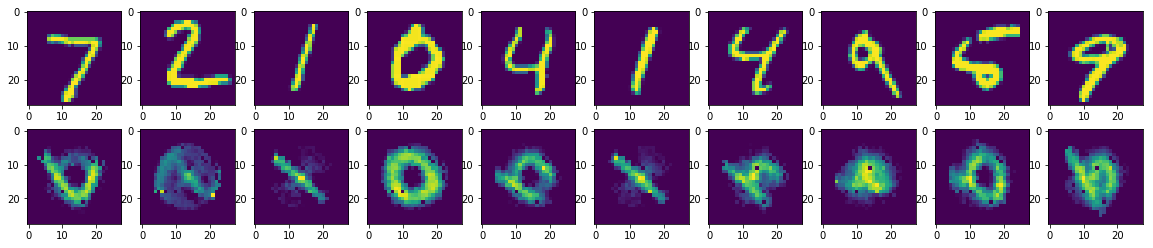

In [94]:
# initialize
init=tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epoch):
        
        num_batches=mnist.train.num_examples//batch_size
        for iteration in range(num_batches):
            X_batch,y_batch=mnist.train.next_batch(batch_size)
            sess.run(train_ops,feed_dict={X:X_batch})
            
        train_loss=loss.eval(feed_dict={X:X_batch})
        print("epoch {} loss {}".format(epoch,train_loss))
    
    results=output_layer.eval(feed_dict={X:mnist.test.images[:num_test_images]})
    
    #Comparing original images with reconstructions
    f,a=plt.subplots(2,10,figsize=(20,4))
    for i in range(num_test_images):
        a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)))
        a[1][i].imshow(np.reshape(results[i],(28,28)))

#### Train c_lambda=0.1

epoch 0 loss 38.01204299926758
epoch 1 loss 40.18955612182617
epoch 2 loss 35.367431640625
epoch 3 loss 32.09087371826172
epoch 4 loss 34.308074951171875


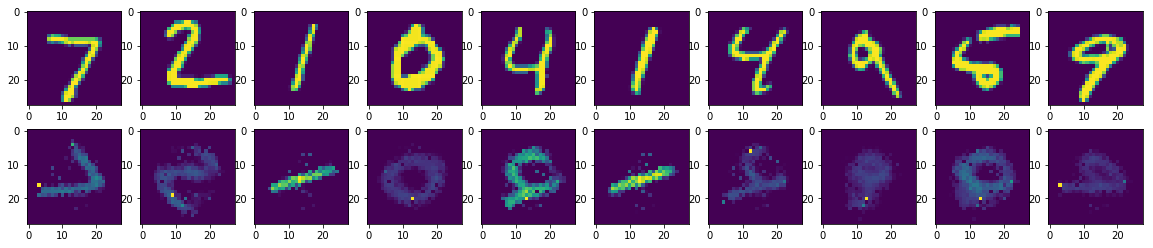

In [98]:
# initialize
init=tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epoch):
        
        num_batches=mnist.train.num_examples//batch_size
        for iteration in range(num_batches):
            X_batch,y_batch=mnist.train.next_batch(batch_size)
            sess.run(train_ops,feed_dict={X:X_batch})
            
        train_loss=loss.eval(feed_dict={X:X_batch})
        print("epoch {} loss {}".format(epoch,train_loss))
    
    results=output_layer.eval(feed_dict={X:mnist.test.images[:num_test_images]})
    
    #Comparing original images with reconstructions
    f,a=plt.subplots(2,10,figsize=(20,4))
    for i in range(num_test_images):
        a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)))
        a[1][i].imshow(np.reshape(results[i],(28,28)))

#### Train with loss : MSE

In [95]:
loss= loss_fn(output_layer, X) # original

optimizer=tf.train.AdamOptimizer(lr)
train_ops=optimizer.minimize(loss)

epoch 0 loss 0.02280101366341114
epoch 1 loss 0.019023597240447998
epoch 2 loss 0.017548151314258575
epoch 3 loss 0.017659759148955345
epoch 4 loss 0.01763537898659706


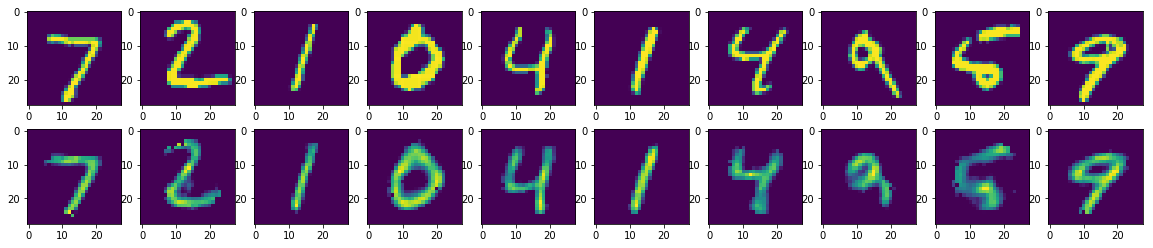

In [96]:
# initialize
init=tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epoch):
        
        num_batches=mnist.train.num_examples//batch_size
        for iteration in range(num_batches):
            X_batch,y_batch=mnist.train.next_batch(batch_size)
            sess.run(train_ops,feed_dict={X:X_batch})
            
        train_loss=loss.eval(feed_dict={X:X_batch})
        print("epoch {} loss {}".format(epoch,train_loss))
    
    results=output_layer.eval(feed_dict={X:mnist.test.images[:num_test_images]})
    
    #Comparing original images with reconstructions
    f,a=plt.subplots(2,10,figsize=(20,4))
    for i in range(num_test_images):
        a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)))
        a[1][i].imshow(np.reshape(results[i],(28,28)))